In [14]:
import numpy as np
from caffe2.python import workspace, core, model_helper, brew, optimizer, utils
from caffe2.proto import caffe2_pb2
import matplotlib.pyplot as plt

In [15]:
# randomly creates segmentation images with noise + ground truth
def get_data(batchsize, numsq=1) :
    data = []
    gt_segmentation = []
    sz = 64
    classes = 3
    for i in range(batchsize) :
        l = np.zeros((sz,sz,classes))
        if classes>1 :
            l[:,:,0] = 1
        for i in range(np.random.randint(0,numsq+1)) :
            s = np.random.randint(5, 20)
            x = np.random.randint(0, sz-s)
            y = np.random.randint(0, sz-s)
            l[x:x+s,y:y+s,0] = 0

            c = np.random.randint(1, classes)
            l[x:x+s,y:y+s,c] = 1

        noise = np.random.normal(0, 0.004, (sz,sz,classes))
        data.append(np.copy(l)+noise)
        l = 1 * (np.argmax(l,axis=2)[...,np.newaxis] > 0)
        gt_segmentation.append(l)
    return np.array(data).astype('float32'), np.array(gt_segmentation).astype('float32')

(1, 64, 64, 3)
(1, 64, 64, 1)
1.0
0.0
1.0139
-0.0189519


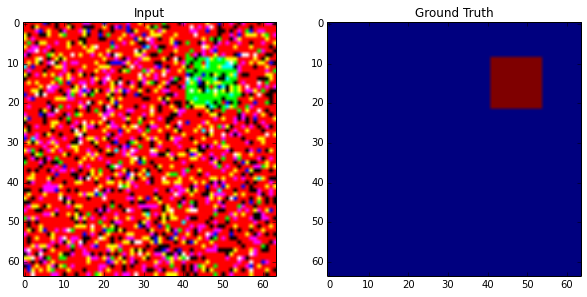

In [16]:
%matplotlib inline

a,b=get_data(1)
print(a.shape)
print(b.shape)
print(np.max(b))
print(np.min(b))
print(np.max(a))
print(np.min(a))

fig, sub = plt.subplots(ncols=2, figsize=(10, 5))

sub[0].set_title('Input')
sub[0].imshow(a[0,:,:,:])

sub[1].set_title('Ground Truth')
sub[1].imshow(b[0,:,:,0])

plt.show()

In [17]:
def uNetModel(model,data,is_test):
    
    weight_init=("MSRAFill", {})
    
    # encoder
    conv1_1 = brew.conv(model,data,'conv1_1',dim_in=3,dim_out=16,kernel=3,pad=1,weight_init=weight_init)
    relu1_1 = brew.relu(model,conv1_1,'relu1_1')
    drop1_1 = brew.dropout(model, relu1_1, 'drop1_1',ratio=0.1,is_test=is_test)
    conv1_2 = brew.conv(model,drop1_1,'conv1_2',dim_in=16,dim_out=16,kernel=3,pad=1,weight_init=weight_init)
    relu1_2 = brew.relu(model,conv1_2,'relu1_2')
    pool1 = brew.max_pool(model, relu1_2, 'pool1', kernel=2, stride=2)
    
    conv2_1 = brew.conv(model,pool1,'conv2_1',dim_in=16,dim_out=32,kernel=3,pad=1,weight_init=weight_init)
    relu2_1 = brew.relu(model,conv2_1,'relu2_1')
    drop2_1 = brew.dropout(model, relu2_1, 'drop2_1',ratio=0.2,is_test=is_test)
    conv2_2 = brew.conv(model,drop2_1,'conv2_2',dim_in=32,dim_out=32,kernel=3,pad=1,weight_init=weight_init)
    relu2_2 = brew.relu(model,conv2_2,'relu2_2')
    pool2 = brew.max_pool(model, relu2_2, 'pool2', kernel=2, stride=2)
    
    conv3_1 = brew.conv(model,pool2,'conv3_1',dim_in=32,dim_out=64,kernel=3,pad=1,weight_init=weight_init)
    relu3_1 = brew.relu(model,conv3_1,'relu3_1')
    drop3_1 = brew.dropout(model, relu3_1, 'drop3_1',ratio=0.3,is_test=is_test)
    conv3_2 = brew.conv(model,drop3_1,'conv3_2',dim_in=64,dim_out=64,kernel=3,pad=1,weight_init=weight_init)
    relu3_2 = brew.relu(model,conv3_2,'relu3_2')
    pool3 = brew.max_pool(model, relu3_2, 'pool3', kernel=2, stride=2)
    
    conv4_1 = brew.conv(model,pool3,'conv4_1',dim_in=64,dim_out=128,kernel=3,pad=1,weight_init=weight_init)
    relu4_1 = brew.relu(model,conv4_1,'relu4_1')
    drop4_1 = brew.dropout(model, relu4_1, 'drop4_1',ratio=0.4,is_test=is_test)
    conv4_2 = brew.conv(model,drop4_1,'conv4_2',dim_in=128,dim_out=128,kernel=3,pad=1,weight_init=weight_init)
    relu4_2 = brew.relu(model,conv4_2,'relu4_2')
    pool4 = brew.max_pool(model, relu4_2, 'pool4', kernel=2, stride=2)
    
    conv5_1 = brew.conv(model,pool4,'conv5_1',dim_in=128,dim_out=256,kernel=3,pad=1,weight_init=weight_init)
    relu5_1 = brew.relu(model,conv5_1,'relu5_1')
    drop5_1 = brew.dropout(model, relu5_1, 'drop5_1',ratio=0.5,is_test=is_test)
    conv5_2 = brew.conv(model,drop5_1,'conv5_2',dim_in=256,dim_out=256,kernel=3,pad=1,weight_init=weight_init)
    relu5_2 = brew.relu(model,conv5_2,'relu5_2')
    
    # deconder
    deConv6_1 = brew.conv_transpose(model,relu5_2,'dConv6_1',dim_in=256,dim_out=128,kernel=2, stride=2, weight_init=weight_init)
    concat6_1 = brew.concat(model,[deConv6_1,relu4_2],'concat6_1')
    conv6_1 = brew.conv(model,concat6_1,'conv6_1',dim_in=256,dim_out=128,kernel=3,pad=1,weight_init=weight_init)
    relu6_1 = brew.relu(model,conv6_1,'relu6_1')
    drop6_1 = brew.dropout(model, relu6_1, 'drop6_1',ratio=0.4,is_test=is_test)
    conv6_2 = brew.conv(model,drop6_1,'conv6_2',dim_in=128,dim_out=128,kernel=3,pad=1,weight_init=weight_init)
    relu6_2 = brew.relu(model,conv6_2,'relu6_2')
    
    deConv7_1 = brew.conv_transpose(model,relu6_2,'dConv7_1',dim_in=128,dim_out=64,kernel=2, stride=2, weight_init=weight_init)
    concat7_1 = brew.concat(model,[deConv7_1,relu3_2],'concat7_1')
    conv7_1 = brew.conv(model,concat7_1,'conv7_1',dim_in=128,dim_out=64,kernel=3,pad=1,weight_init=weight_init)
    relu7_1 = brew.relu(model,conv7_1,'relu7_1')
    drop7_1 = brew.dropout(model, relu7_1, 'drop7_1',ratio=0.3,is_test=is_test)
    conv7_2 = brew.conv(model,drop7_1,'conv7_2',dim_in=64,dim_out=64,kernel=3,pad=1,weight_init=weight_init)
    relu7_2 = brew.relu(model,conv7_2,'relu7_2')
    
    deConv8_1 = brew.conv_transpose(model,relu7_2,'dConv8_1',dim_in=64,dim_out=32,kernel=2, stride=2, weight_init=weight_init)
    concat8_1 = brew.concat(model,[deConv8_1,relu2_2],'concat8_1')
    conv8_1 = brew.conv(model,concat8_1,'conv8_1',dim_in=64,dim_out=32,kernel=3,pad=1,weight_init=weight_init)
    relu8_1 = brew.relu(model,conv8_1,'relu8_1')
    drop8_1 = brew.dropout(model, relu8_1, 'drop8_1',ratio=0.2,is_test=is_test)
    conv8_2 = brew.conv(model,drop8_1,'conv8_2',dim_in=32,dim_out=32,kernel=3,pad=1,weight_init=weight_init)
    relu8_2 = brew.relu(model,conv8_2,'relu8_2')
    
    deConv9_1 = brew.conv_transpose(model,relu8_2,'dConv9_1',dim_in=32,dim_out=16,kernel=2, stride=2, weight_init=weight_init)
    concat9_1 = brew.concat(model,[deConv9_1,relu1_2],'concat9_1')
    conv9_1 = brew.conv(model,concat9_1,'conv9_1',dim_in=32,dim_out=16,kernel=3,pad=1,weight_init=weight_init)
    relu9_1 = brew.relu(model,conv9_1,'relu9_1')
    drop9_1 = brew.dropout(model, relu9_1, 'drop9_1',ratio=0.2,is_test=is_test)
    conv9_2 = brew.conv(model,drop9_1,'conv9_2',dim_in=16,dim_out=16,kernel=3,pad=1,weight_init=weight_init)
    relu9_2 = brew.relu(model,conv9_2,'relu9_2')
    
    output = brew.conv(model, relu9_2, 'output', dim_in=16, dim_out=1, kernel=1, pad=0, stride=1, weight_init=weight_init)
    
    model.net.AddExternalOutput(output)
    output_sigmoid = model.Sigmoid(output, 'output_sigmoid')
    model.net.AddExternalOutput(output_sigmoid)
    
    return output

In [18]:
# add loss and optimizer
def AddTrainingOperators(model):
    loss = model.SigmoidCrossEntropyWithLogits(["output", "mask"], "loss")
    avg_loss = model.AveragedLoss(loss, "avg_loss")
 #   accuracy = model.Accuracy(["output","mask"],'accuracy')
    model.AddGradientOperators([loss])
    opt = optimizer.build_adam(model, base_learning_rate=0.01)

In [19]:
def train(INIT_NET, PREDICT_NET, epochs, batch_size) :
    arg_scope = {"order": "NHWC"}
    data,gt = get_data(batch_size)
    workspace.FeedBlob("data",data)
    workspace.FeedBlob("mask",gt)

    train_model = model_helper.ModelHelper(name="train_net", arg_scope=arg_scope)
    output = uNetModel(train_model,"data",is_test=0)
    AddTrainingOperators(train_model)

    workspace.RunNetOnce(train_model.param_init_net)
    workspace.CreateNet(train_model.net)
    
    for j in range(0,epochs):
        data,gt = get_data(batch_size)
        workspace.FeedBlob("data",data)
        workspace.FeedBlob("mask",gt)
        workspace.RunNet(train_model.net,1)
        print('Average Loss({0}):{1}'.format(j,workspace.FetchBlob("avg_loss")))
    print('Training Done')

    test_model = model_helper.ModelHelper(name='test_net',arg_scope=arg_scope,init_params=False)
    uNetModel(test_model,"data",is_test=1)
    workspace.RunNetOnce(test_model.param_init_net)
    workspace.CreateNet(test_model.net, overwrite=True)

    print '\nsaving test model'
    save_net(INIT_NET, PREDICT_NET, test_model)

In [20]:
def save_net(INIT_NET, PREDICT_NET, model) :
    with open(PREDICT_NET, 'wb') as f:
        f.write(model.net._net.SerializeToString())
    init_net = caffe2_pb2.NetDef()
    for param in model.params:
        #print param
        blob = workspace.FetchBlob(param)
        shape = blob.shape
        op = core.CreateOperator("GivenTensorFill", [], [param],arg=[utils.MakeArgument("shape", shape),utils.MakeArgument("values", blob)])
        init_net.op.extend([op])
    init_net.op.extend([core.CreateOperator("ConstantFill", [], ["data"], shape=get_data(1)[0][0,:,:,:].shape)])
    with open(INIT_NET, 'wb') as f:
        f.write(init_net.SerializeToString())

In [21]:
def load_net(INIT_NET, PREDICT_NET):
    init_def = caffe2_pb2.NetDef()
    with open(INIT_NET, 'r') as f:
        init_def.ParseFromString(f.read())
        workspace.RunNetOnce(init_def.SerializeToString())

    net_def = caffe2_pb2.NetDef()
    with open(PREDICT_NET, 'r') as f:
        net_def.ParseFromString(f.read())
        workspace.CreateNet(net_def.SerializeToString(), overwrite=True)

In [22]:
INIT_NET = '/disk2/Faliu/caffe2/test/model/init_net.pb'
PREDICT_NET = '/disk2/Faliu/caffe2/test/model/predict_net.pb'

train(INIT_NET, PREDICT_NET, epochs=25, batch_size=50)

print '\n********************************************'
print 'loading test model'
# Problems loading batch-norm layer (SpatialBN) here!
load_net(INIT_NET, PREDICT_NET)


Average Loss(0):0.682432711124
Average Loss(1):0.426423549652
Average Loss(2):15.7868309021
Average Loss(3):0.157252714038
Average Loss(4):0.339802235365
Average Loss(5):0.43006208539
Average Loss(6):0.481872171164
Average Loss(7):0.509557247162
Average Loss(8):0.507282018661
Average Loss(9):0.47931393981
Average Loss(10):0.41520935297
Average Loss(11):0.323700606823
Average Loss(12):0.223327130079
Average Loss(13):0.132999837399
Average Loss(14):0.0665511339903
Average Loss(15):0.0300312470645
Average Loss(16):0.0138824330643
Average Loss(17):0.00777660310268
Average Loss(18):0.00454364717007
Average Loss(19):0.00297477236018
Average Loss(20):0.00513809919357
Average Loss(21):0.00479562114924
Average Loss(22):0.00528395269066
Average Loss(23):0.00325443129987
Average Loss(24):0.00445571355522
Training Done

saving test model

********************************************
loading test model


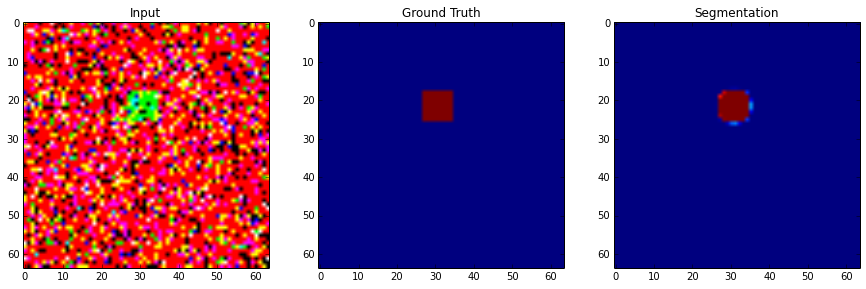

In [24]:
%matplotlib inline

data, gt = get_data(1)
workspace.FeedBlob("data", data)
workspace.RunNet('test_net', 1)
out1 = workspace.FetchBlob("output_sigmoid")

fig, sub = plt.subplots(ncols=3, figsize=(15, 5))

sub[0].set_title('Input')
sub[0].imshow(data[0,:,:,:])

sub[1].set_title('Ground Truth')
sub[1].imshow(gt[0,:,:,0])

sub[2].set_title('Segmentation')
sub[2].imshow(out1[0, :, :, 0])

plt.show()